<a href="https://colab.research.google.com/github/vchandraiitk/datascience/blob/main/Vikas_M3_NB_MiniProject_3_Emotion_Classification_from_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: Speech Emotion Classification

## Problem Statement

Build a model to recognize emotion from speech using Ensemble learning

## Learning Objectives

At the end of the mini-project, you will be able to :

* extract the features from audio data
* implement ML classification algorithms individually and as Ensembles, to classify emotions
* record the voice sample and test it with trained model

## Dataset

**TESS Dataset**

The first dataset chosen for this mini-project is the [TESS](https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/E8H2MF) (Toronto emotional speech set) dataset. It contains 2880 files.  A set of 200 target words were spoken in the carrier phrase "Say the word _____' by two actresses and the sets were recorded in seven different emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). Both actresses spoke English as their first language, were university educated, and had musical training. Audiometric testing indicated that both actresses had thresholds within the normal range.

**Ravdess Dataset**

The second dataset chosen for this mini-project is [Ravdess](https://zenodo.org/record/1188976#.YLczy4XivIU) (The Ryerson Audio-Visual Database of Emotional Speech and Song). This dataset contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

**File naming convention**

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

**Filename identifiers**

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: `03-01-06-01-02-01-12.wav`

    - Audio-only - 03
    - Speech - 01
    - Fearful - 06
    - Normal intensity - 01
    - Statement "dogs" - 02
    - 1st Repetition - 01
    - 12th Actor - 12 Female, as the actor ID number is even.

## Information

**Speech Emotion Recognition (SER)** is the task of recognizing the emotion from  speech, irrespective of the semantics. Humans can efficiently perform this task as a natural part of speech communication, however, the ability to conduct it automatically using programmable devices is a field of active research.

Studies of automatic emotion recognition systems aim to create efficient, real-time methods of detecting the emotions of mobile phone users, call center operators and customers, car drivers, pilots, and many other human-machine communication users. Adding emotions to machines forms an important aspect of making machines appear and act in a human-like manner

Lets gain familiarity with some of the audio based features that are commonly used for SER.

**Mel scale** — The mel scale (derived from the word *melody*) is a perceptual scale of pitches judged by listeners to be equal in distance from one another. The reference point between this scale and normal frequency measurement is defined by assigning a perceptual pitch of 1000 mels to a 1000 Hz tone, 40 dB above the listener's threshold. Above about 500 Hz, increasingly large intervals are judged by listeners to produce equal pitch increments. Refer [here](https://towardsdatascience.com/learning-from-audio-the-mel-scale-mel-spectrograms-and-mel-frequency-cepstral-coefficients-f5752b6324a8) for more detailed information.

**Pitch** — how high or low a sound is. It depends on frequency, higher pitch is high frequency

**Frequency** — speed of vibration of sound, measures wave cycles per second

**Chroma** — Representation for audio where spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma). Computed by summing the log frequency magnitude spectrum across octaves.

**Fourier Transforms** — used to convert from time domain to frequency domain. Time domain shows how signal changes over time. Frequency domain shows how much of the signal lies within each given frequency band over a range of frequencies

**Librosa**

[Librosa](https://librosa.org/doc/latest/index.html) is a Python package, built for speech and audio analytics. It provides modular functions that simplify working with audio data and help in achieving a wide range of applications such as identification of the personal characteristics of different individuals' voice samples, detecting emotions from audio samples etc.

For further details on the Librosa package, refer [here](https://conference.scipy.org/proceedings/scipy2015/pdfs/brian_mcfee.pdf).


### **Kaggle Competition**

Please refer to the link for viewing the
[Kaggle Competition Document](https://drive.google.com/file/d/1V3Y8Q3M03Atn9oM1zqmW6jpuzSYm445e/view?usp=drive_link) and join the Kaggle Competition using the hyperlink given in this document under '*Kaggle* Competition site'.


## Grading = 10 Points

In [112]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
os.chdir('/content/drive/MyDrive/ISC/Mini Project/M3_NB_MiniProject_3')

In [114]:
#@title Download the datasets and install packages
#!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Ravdess_Tess.zip
#!unzip -qq Ravdess_Tess.zip
# Install packages
!pip -qq install librosa soundfile
!pip -qq install wavio
print("Datasets downloaded successfully!")

Datasets downloaded successfully!


### Import Neccesary Packages

In [115]:
import librosa
import librosa.display
import soundfile
import os, glob, pickle
import numpy as np
import pandas as pd
import IPython.display as ipd
from IPython.display import Audio
from matplotlib import pyplot as plt
from datetime import datetime
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
import warnings
warnings.filterwarnings('ignore')
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import VotingClassifier

### Work-Flow

* Load the TESS audio data and extract features and labels

* Load the Ravdess audio data and extract features

* Combine both the audio dataset features

* Train and test the model with TESS + Ravdess Data

* Record the team audio samples and add them to TESS + Ravdess data

* Train and test the model with TESS + Ravdess + Team Recorded (combined) data

* Test each of the models with live audio sample recording.

### Load the Tess data and Ravdess data audio files (1 point)

Hint: `glob.glob`

In [116]:
# YOUR CODE HERE (Task-1)
Tess_files = glob.glob("Tess/*/*.wav")
Ravdess_files = glob.glob("ravdess/*/*.wav")
print("Number of TESS files:", len(Tess_files))
print("Number of Ravdess files:", len(Ravdess_files))

Number of TESS files: 2679
Number of Ravdess files: 1168


#### Play the sample audio

In [117]:
# YOUR CODE HERE (Task-2)
ipd.Audio(Tess_files[0])
Audio(Tess_files[0], autoplay=True)

In [118]:
# YOUR CODE HERE (Task-2)
ipd.Audio(Tess_files[550])
print(Tess_files[550])
Audio(Tess_files[550], autoplay=True)

Tess/OAF_Sad/OAF_turn_sad.wav


In [119]:
ipd.Audio(Ravdess_files[0])
Audio(Ravdess_files[0], autoplay=True)

### Data Exploration and Visualization (1 point)

#### Visualize the distribution of all the labels

In [120]:
# YOUR CODE HERE (Task-3)
data_dir = 'Tess/'
labels = []

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for file in os.listdir(label_dir):
            if file.endswith('.wav'):  # or other audio file extensions
                label = label.replace("OAF_", "")
                label = label.replace("YAF_", "")
                #size = file.split('_').__len__()
                #label = file.split('_')[size-1].split('.')[0]
                labels.append(label.lower())
                #print(f"Label: {label}, File: {file}")
len(labels)

2679

label
disgust      391
surprised    387
happy        383
angry        382
fear         379
sad          379
neutral      378
Name: count, dtype: int64


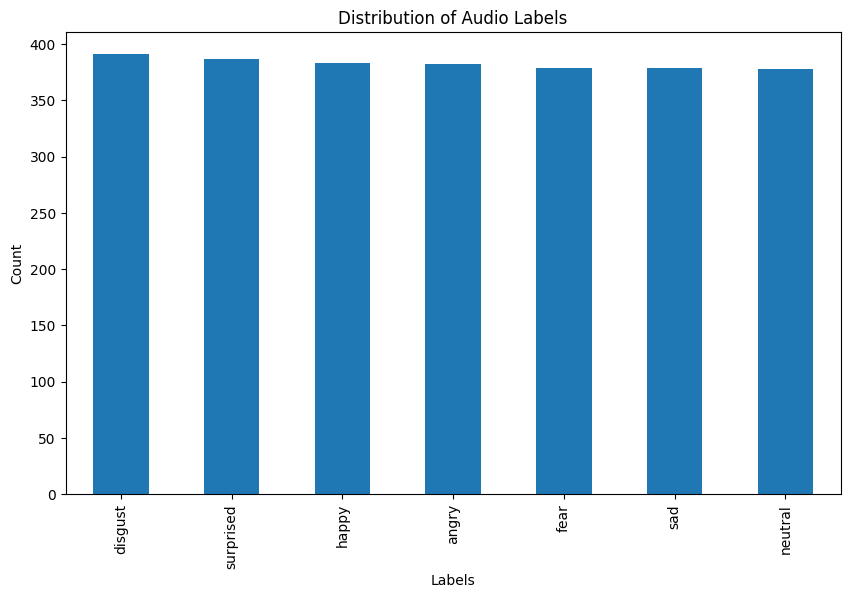

In [121]:
df_tess = pd.DataFrame(labels, columns=['label'])
#print(df_tess)
label_counts = df_tess['label'].value_counts()
print(label_counts)
# Bar plot
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Audio Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

#### Visualize sample audio signal using librosa

label
sad          183
fear         182
surprised    182
disgust      180
angry        179
happy        174
neutral       88
Name: count, dtype: int64


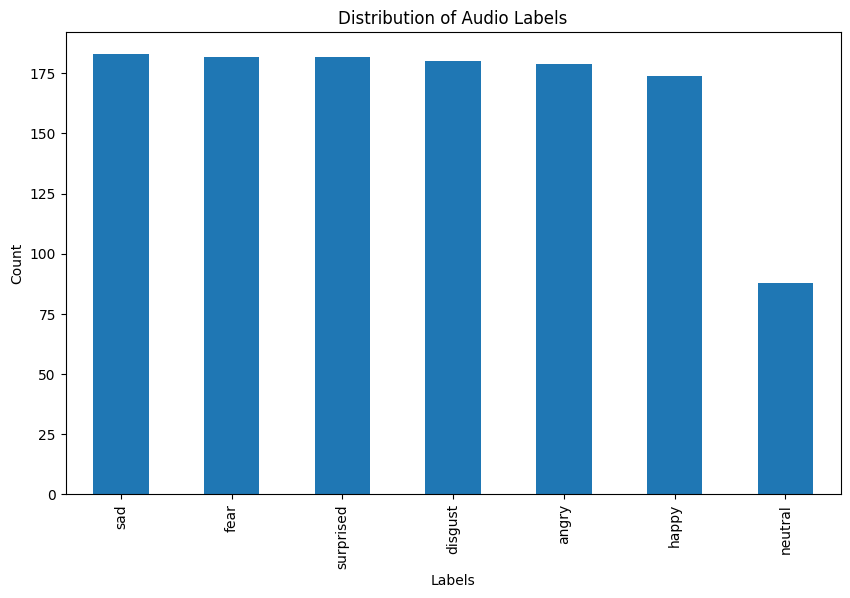

In [122]:
#Ravdess_files = glob.glob("ravdess/*/*.wav")
data_dir_rav = 'ravdess/'
labels_rav = []

emotion_dictonary={'01':'neutral', '02':'calm', '03':'happy', '04':'sad', '05':'angry', '06':'fearful', '07':'disgust', '08':'surprised'}


for label in os.listdir(data_dir_rav):
    label_dir = os.path.join(data_dir_rav, label)
    if os.path.isdir(label_dir):
        for file in os.listdir(label_dir):
            if file.endswith('.wav'):  # or other audio file extensions

                label = file.split('_')[1].split('.')[0]
                labels_rav.append(label.lower())
                #print(f"Label: {label}, File: {file}")

df_ravdess = pd.DataFrame(labels_rav, columns=['label'])
label_counts = df_ravdess['label'].value_counts()
print(label_counts)
# Bar plot
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Audio Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

label
disgust      571
surprised    569
sad          562
angry        561
fear         561
happy        557
neutral      466
Name: count, dtype: int64


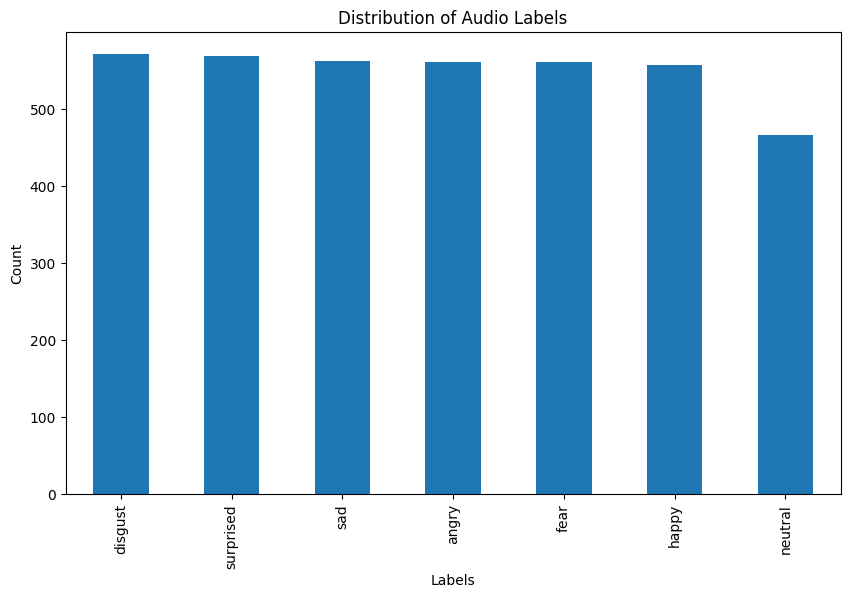

In [123]:
df_combined = pd.concat([df_ravdess, df_tess], ignore_index=True)
label_counts = df_combined['label'].value_counts()
print(label_counts)
# Bar plot
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Audio Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

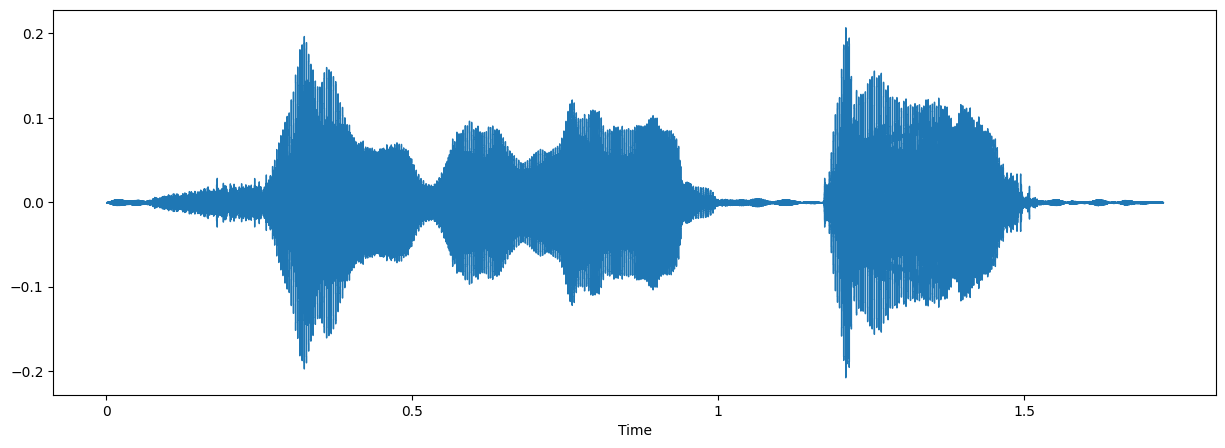

In [124]:
# YOUR CODE HERE (Task-4)
sample_audio_path = Tess_files[0]

# librosa is used for analyzing and extracting features of an audio signal
data, sampling_rate = librosa.load(sample_audio_path)
plt.figure(figsize=(15, 5))

# librosa.display.waveshow is used to plot waveform of amplitude vs time
librosa.display.waveshow(data, sr=sampling_rate)
plt.show()

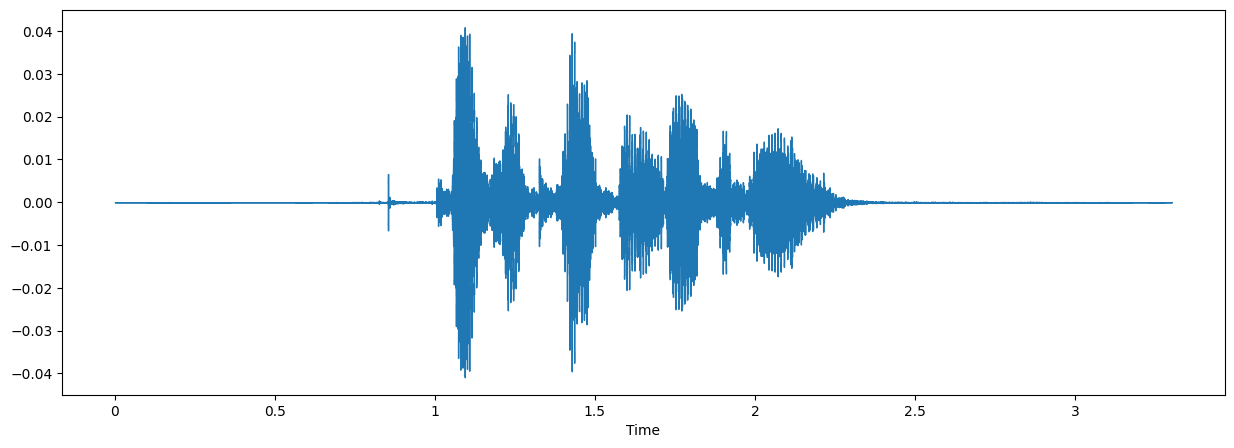

In [125]:
# YOUR CODE HERE (Task-4.1)
sample_audio_path = Ravdess_files[0]

# librosa is used for analyzing and extracting features of an audio signal
data, sampling_rate = librosa.load(sample_audio_path)
plt.figure(figsize=(15, 5))

# librosa.display.waveshow is used to plot waveform of amplitude vs time
librosa.display.waveshow(data, sr=sampling_rate)
plt.show()

### Feature extraction (2 points)

Read one WAV file at a time using `Librosa`. An audio time series in the form of a 1-dimensional array for mono or 2-dimensional array for stereo, along with time sampling rate (which defines the length of the array), where the elements within each of the arrays represent the amplitude of the sound waves is returned by `librosa.load()` function. Refer to the supplementary notebook ('Audio feature extraction')

To know more about Librosa, explore the [link](https://librosa.org/doc/latest/feature.html)

In [126]:
# YOUR CODE HERE (Task-5)
def extract_feature(file_name):
    # load audio
    X, sample_rate = librosa.load(file_name)
    # apply stft()
    stft=np.abs(librosa.stft(X))
    result=np.array([])
    # compute mfcc
    mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    # combine the features
    result=np.hstack((result, mfccs))
    # compute chroma features and combine
    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    result=np.hstack((result, chroma))
    # compute melspectrogram and combine
    mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
    result=np.hstack((result, mel))
    return result
sample_feature = extract_feature(Tess_files[0]) #,mfcc=True, chroma=True, mel=True)

In [127]:
len(sample_feature)

180

In [128]:
def extract_feature1(file_name):
    # Load audio file
    X, sample_rate = librosa.load(file_name)

    # Apply STFT
    stft = np.abs(librosa.stft(X))
    result = np.array([])

    # Compute MFCC features
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfccs))
    print(len(result))
    # Compute chroma features
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma))
    print(len(result))
    # Compute melspectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    print(len(result))
    # Compute zero-crossing rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=X).T, axis=0)
    result = np.hstack((result, zcr))
    print(len(result))
    # Compute spectral centroid
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=X, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_centroid))
    print(len(result))
    # Compute spectral bandwidth
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=X, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_bandwidth))
    print(len(result))
    return result
sample_feature = extract_feature(Tess_files[0])

In [129]:
len(sample_feature)

180

#### Create a dictionary or a function to encode the emotions

In [130]:
# YOUR CODE HERE (Task-6)
emotions = {'neutral': 1, 'calm': 2, 'happy': 3, 'sad': 4, 'angry': 5, 'fear': 6, 'disgust': 7, 'surprised': 8}
def emotion_encoder(emotion, emotion_dict=emotions):
    #print(emotion)
    emotion = emotion.replace("OAF_", "")
    emotion = emotion.replace("YAF_", "")
    return emotion_dict.get(emotion, None)
emotion_encoder("sad")

4

#### TESS data feature extraction

In [192]:
# YOUR CODE HERE (Task-7)
df_Tess = pd.DataFrame(columns=['feature', 'label'])
for file in Tess_files:
    feature = extract_feature(file)
    #label = emotion_encoder(file.split('/')[1])
    #print(file)
    size = file.split('_').__len__()
    label = file.split('_')[size-1].split('.')[0]
    #print(label)
    df_Tess.loc[len(df_Tess)] = [feature, emotions.get(label)]
    #sample_feature = extract_feature(Tess_files[0]) #,mfcc=True, chroma=True, mel=True)

In [193]:
df_Tess.label.unique()

array([6, 8, 4, 5, 7, 3, 1])

#### Ravdess data feature extraction

In [194]:
# YOUR CODE HERE (Task-8)
df_ravdess = pd.DataFrame(columns=['feature', 'label'])
for file in Ravdess_files:
    feature = extract_feature(file)
    emotion = file.split('_')[2].split('.')[0]
    #print(emotion_encoder(emotion))
    df_ravdess.loc[len(df_ravdess)] = [feature, emotion_encoder(emotion)]

In [196]:
df_ravdess.head(5)
df_ravdess.label.unique()

array([1, 3, 4, 5, 6, 7, 8])

#### Save the features

It is best advised to save the features in dataframe and maintain so that feature extraction step is not required to be performed every time.

* Make a DataFrame with features and labels

* Write dataframe into `.CSV` file and save it offline.

In [197]:
# YOUR CODE HERE (Task-9)
df_combined = pd.concat([df_Tess, df_ravdess], ignore_index=True)
#df_Tess.to_csv('Tess_Feature.csv', index=False, sep=',')
#df_ravdess.to_csv('Ravdess_Feature.csv', index=False, sep=',')
#df_combined.to_csv('Combined_Feature.csv', index=False, sep=',')

In [198]:
df_combined.head()

,feature,label
0,"[-434.4168395996094, 61.591835021972656, 1.869...",6
1,"[-433.82464599609375, 70.08883666992188, 12.93...",6
2,"[-443.5323181152344, 38.71072006225586, 11.385...",6
3,"[-405.6277770996094, 61.29931640625, 7.4779605...",6
4,"[-491.3377685546875, 53.490482330322266, 20.95...",6


In [137]:
# #Flattening For feature extraction
features_expanded = pd.DataFrame(df_combined['feature'].tolist())

# # Optionally, rename the columns if needed, for example:
# features_expanded.columns = [f'feature_{i}' for i in range(features_expanded.shape[1])]

# # Drop the original 'features' column and join the new columns
df = df_combined.drop(columns=['feature']).join(features_expanded)
#df.label.value_counts()

In [138]:
features_expanded

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,-434.416840,61.591835,1.869825,-8.288072,2.913275,3.220161,-13.606009,-0.346508,-10.710855,3.896623,...,6.348570e-04,3.547018e-04,3.590935e-04,3.340134e-04,2.192557e-04,1.787794e-04,1.742297e-04,1.155819e-04,7.560206e-05,6.435729e-06
1,-433.824646,70.088837,12.938360,-21.756363,-6.834160,4.844457,-11.890791,-0.407226,-15.726844,0.942807,...,1.314877e-03,1.047327e-03,7.489119e-04,6.667980e-04,3.715819e-04,3.327320e-04,2.576741e-04,2.134585e-04,9.676426e-05,6.060719e-06
2,-443.532318,38.710720,11.385891,5.367714,8.344028,0.096640,-12.813403,-2.515016,-12.204514,0.855093,...,1.926462e-03,8.649991e-04,5.960083e-04,5.421030e-04,6.094637e-04,5.823917e-04,5.675435e-04,3.786204e-04,1.720628e-04,1.369978e-05
3,-405.627777,61.299316,7.477961,-13.963837,-1.340553,2.632162,-11.384148,-0.700052,-14.756960,3.874685,...,1.396934e-03,8.555939e-04,9.766837e-04,8.364618e-04,5.921929e-04,7.479609e-04,7.477056e-04,6.259676e-04,3.596814e-04,3.472380e-05
4,-491.337769,53.490482,20.951565,8.448865,8.880781,0.637741,-6.358855,1.899915,-14.149590,-2.984139,...,3.100223e-04,2.635255e-04,3.273340e-04,2.872967e-04,2.029685e-04,1.482188e-04,1.313815e-04,9.576362e-05,5.930067e-05,4.973593e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3842,-597.907654,40.811817,-32.411892,11.839550,-27.056583,-0.210300,-22.883425,-10.650916,-8.968591,-6.769902,...,3.706436e-15,1.913067e-15,1.959026e-15,1.391101e-15,6.789701e-16,5.136614e-16,3.938156e-16,7.465623e-16,1.199344e-15,1.000241e-15
3843,-545.432312,55.698841,-31.927088,9.405981,-28.413462,-3.130087,-18.835529,-6.613997,-11.114130,-3.108346,...,1.507500e-14,1.088551e-14,9.302079e-15,7.090779e-15,4.602935e-15,3.647313e-15,3.109193e-15,3.537372e-15,4.503422e-15,4.292062e-15
3844,-554.988159,48.646824,-36.022522,13.183099,-28.419792,-6.001969,-20.985855,-6.426065,-10.043091,-0.084535,...,4.470183e-13,4.007210e-13,3.663232e-13,3.400855e-13,3.194283e-13,3.032090e-13,2.909937e-13,2.823455e-13,2.775231e-13,2.726788e-13
3845,-509.826263,47.763008,-28.615173,22.230803,-28.934071,9.568296,-21.404312,-1.329534,-5.723031,-3.138276,...,3.398366e-14,1.218177e-14,5.643961e-15,3.699083e-15,2.092237e-15,1.390136e-15,1.053049e-15,2.998987e-15,3.468829e-15,2.155022e-15


#### Split the data into train and test

In [199]:
# YOUR CODE HERE (Task-10)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_expanded, df['label'].values, test_size=0.2, random_state=42)

### Train the model with TESS + Ravdess data (2 points)

* Apply different ML algorithms (eg. DecisionTree, RandomForest, etc.) and find the model with best performance

In [140]:
# YOUR CODE HERE
# Writing Implementations of different algorithms here
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
scores = []
best_estimator = {}

def model_predict_evaluate(X_train, y_train, X_test, y_test):
    classification_models = {
        'LogisticRegression': LogisticRegression(),
        'DecisionTreeClassifier': DecisionTreeClassifier(),
        'RandomForestClassifier': RandomForestClassifier()
    }

    param_grids = {
        'LogisticRegression': {
            'C': [0.1, 1, 10],
            'solver': ['liblinear']
        },
        'DecisionTreeClassifier': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 10, 20]
        },
        'RandomForestClassifier': {
            'n_estimators': [10, 50, 100],
            'max_features': ['sqrt', 'log2']
        }
    }
    best_model = None
    best_score = 0

    for model_name, model in classification_models.items():
        grid_search = GridSearchCV(model, param_grids[model_name], scoring='f1_weighted', cv=5)
        grid_search.fit(X_train, y_train)
        best_estimator[model_name] = grid_search.best_estimator_
        score = f1_score(y_test, best_estimator[model_name].predict(X_test), average='weighted')
        scores.append((model_name, round(score, 4)))

        if best_model is None or best_score < score:
            best_model = best_estimator[model_name]
            best_score = score

    # Make it pretty
    scores_df = pd.DataFrame(scores, columns=['Classifier', 'f1-Score'])
    scores_df.sort_values(by='f1-Score', axis=0, ascending=False, inplace=True)

    return scores_df, best_model, scores

# Example usage:
# Assuming X_train, y_train, X_test, and y_test are already defined
scores_df, best_model, scores = model_predict_evaluate(X_train, y_train, X_test, y_test)
print("Best model is ", type(best_model).__name__)
print(scores_df)
print(scores)

Best model is  RandomForestClassifier
               Classifier  f1-Score
2  RandomForestClassifier    0.8529
0      LogisticRegression    0.8261
1  DecisionTreeClassifier    0.7459
[('LogisticRegression', 0.8261), ('DecisionTreeClassifier', 0.7459), ('RandomForestClassifier', 0.8529)]


In [141]:
best_estimator

{'LogisticRegression': LogisticRegression(C=1, solver='liblinear'),
 'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=20),
 'RandomForestClassifier': RandomForestClassifier(max_features='log2')}

#### Apply the voting classifier

In [142]:
# YOUR CODE HERE (Task-12)
voting_clf = VotingClassifier(
        estimators=[(name, estimator) for name, estimator in best_estimator.items()],
        voting='soft'  # Use 'hard' for majority voting
    )
voting_clf.fit(X_train, y_train)
voting_score = f1_score(y_test, voting_clf.predict(X_test), average='weighted')
for s in scores:
    if s[0]=='VotingClassifier':
         scores.remove(s)
scores.append(('VotingClassifier', round(voting_score, 4)))

In [149]:
scores

[('LogisticRegression', 0.8261),
 ('DecisionTreeClassifier', 0.7459),
 ('RandomForestClassifier', 0.8529),
 ('VotingClassifier', 0.8007)]

In [153]:
MODEL = best_model
kaggle_test_wav_files = glob.glob("/content/drive/MyDrive/ISC/Mini Project/M3_NB_MiniProject_3/kaggle/*.wav")
print("Number of wav files with Team data = ",len(kaggle_test_wav_files))

Number of wav files with Team data =  201


In [157]:
import os
import csv
import numpy as np
import pandas as pd
import random

# Ensure reproducibility
np.random.seed(42)
random.seed(42)

def write_to_csv(filename, name, value):
    mode = 'a' if os.path.isfile(filename) else 'w'
    with open(filename, mode, newline='') as file:
        writer = csv.writer(file)
        if mode == 'w':
            writer.writerow(['Id', 'Label'])
        writer.writerow([name, value])

def predict_kaggle_update_csv():
    for file in kaggle_test_wav_files:
        features = extract_feature(file).reshape(1, -1)
        predicted = best_model.predict(features)
        idx_emotion = list(emotions.values()).index(predicted[0])
        write_to_csv('kaggle_results.csv', os.path.basename(file).split(".")[0], list(emotions.keys())[idx_emotion])

# Execute prediction and CSV update
predict_kaggle_update_csv()

# Read and sort the results
df_kaggle_results = pd.read_csv("kaggle_results.csv")
df_kaggle_results_sorted = df_kaggle_results.sort_values(by='Id')
df_kaggle_results_sorted.to_csv("kaggle_results_sorted.csv", index=False)

print("Predictions written to 'kaggle_results_sorted.csv'")


Predictions written to 'kaggle_results_sorted.csv'


### Train the model with TESS + Ravdess + Team recorded data (4 points)

* Record the audio samples (team data), extract features and combine with TESS + Ravdess data features
  - Record and gather all the team data samples with proper naming convention in separate folder

    **Hint:** Follow the supplementary notebook to record team data

  - Each team member must record 2 samples for each emotion (Use similar sentences as given in TESS data)

* Train the different ML algorithms and find the model with best performance

#### Load the team data

In [200]:
# YOUR CODE HERE (Task-13)
Team_files = glob.glob("/content/drive/MyDrive/ISC/Mini Project/M3_NB_MiniProject_3/Team/*/*.wav")
#Ravdess_files = glob.glob("ravdess/*/*.wav")
print("Number of Team files:", len(Team_files))

Number of Team files: 32


#### Extracting features of team data and combine with TESS + Ravdess

In [201]:
# YOUR CODE HERE (Task-14)
df_team = pd.DataFrame(columns=['feature', 'label'])
for file in Team_files:
    feature = extract_feature(file)
    length = file.split('_').__len__()-1
    emotion = file.split('_')[length].split('.')[0]
    #print(emotion)
    #print(emotion_encoder(emotion))
    df_team.loc[len(df_team)] = [feature, emotion_encoder(emotion)]

In [202]:
df_team

,feature,label
0,"[-392.7487487792969, 70.4671859741211, 11.4312...",1
1,"[-433.1466369628906, 55.59064483642578, 24.225...",1
2,"[-481.53900146484375, 76.8440933227539, 24.805...",2
3,"[-467.25384521484375, 73.22505187988281, 20.93...",2
4,"[-413.7569580078125, 60.54413986206055, 22.889...",3
5,"[-398.70257568359375, 58.72226333618164, 8.063...",3
6,"[-428.691650390625, 61.101890563964844, 10.949...",4
7,"[-423.7263488769531, 83.76544952392578, 19.889...",4
8,"[-390.1185607910156, 42.02067184448242, 4.3159...",5
9,"[-370.74761962890625, 64.05171203613281, 1.478...",5


In [204]:

# YOUR CODE HERE (Task-9)
df_combined = pd.concat([df_Tess, df_ravdess, df_team], ignore_index=True)
#df_Tess.to_csv('Tess_Feature.csv', index=False, sep=',')
#df_ravdess.to_csv('Ravdess_Feature.csv', index=False, sep=',')
#df_combined.to_csv('Combined_Feature.csv', index=False, sep=',')
df_combined.label.unique()

array([6, 8, 4, 5, 7, 3, 1, 2])

#### Train the different ML algorithms

In [216]:
features_expanded = pd.DataFrame(df_combined['feature'].tolist())
df = df_combined.drop(columns=['feature']).join(features_expanded)
X_train, X_test, y_train, y_test = train_test_split(features_expanded, df['label'].values, test_size=0.2, random_state=42)

In [217]:
df_combined.label.unique()
df_combined.head()
y_test

array([6, 8, 7, 4, 1, 6, 1, 5, 7, 5, 1, 8, 4, 8, 1, 6, 6, 7, 8, 3, 8, 8,
       8, 3, 8, 3, 5, 7, 1, 3, 4, 8, 4, 8, 1, 4, 7, 1, 8, 6, 1, 4, 1, 4,
       6, 3, 7, 6, 4, 1, 1, 8, 4, 4, 1, 5, 8, 3, 4, 8, 8, 6, 8, 7, 1, 5,
       4, 8, 4, 7, 5, 6, 4, 4, 7, 7, 7, 1, 3, 3, 7, 8, 3, 3, 5, 4, 8, 7,
       4, 7, 3, 7, 6, 3, 4, 6, 3, 1, 6, 4, 1, 6, 6, 7, 1, 8, 4, 6, 6, 5,
       1, 6, 1, 1, 3, 3, 7, 7, 7, 4, 1, 7, 4, 5, 8, 5, 6, 7, 3, 4, 8, 6,
       7, 4, 1, 8, 3, 6, 8, 4, 7, 8, 7, 8, 3, 1, 3, 4, 8, 7, 1, 3, 1, 4,
       6, 7, 5, 7, 5, 7, 6, 8, 3, 4, 5, 1, 3, 1, 8, 6, 5, 7, 3, 1, 6, 4,
       8, 1, 8, 6, 4, 7, 5, 1, 6, 1, 8, 3, 3, 6, 4, 6, 1, 6, 6, 1, 4, 5,
       6, 6, 8, 4, 6, 1, 4, 6, 7, 7, 7, 4, 8, 6, 7, 5, 8, 8, 6, 6, 5, 4,
       5, 6, 8, 3, 6, 5, 7, 3, 8, 8, 3, 4, 6, 6, 4, 4, 7, 5, 3, 3, 4, 5,
       6, 3, 3, 5, 7, 1, 5, 4, 1, 8, 4, 7, 4, 8, 1, 8, 6, 5, 3, 3, 8, 7,
       4, 3, 5, 3, 5, 8, 4, 3, 4, 5, 7, 8, 7, 5, 1, 3, 6, 7, 1, 6, 7, 4,
       3, 8, 5, 7, 3, 1, 5, 1, 4, 7, 1, 3, 4, 6, 4,

In [218]:
# YOUR CODE HERE (Task-15)
# Writing Implementations of different algorithms here
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
scores = []
best_estimator = {}

def model_predict_evaluate(X_train, y_train, X_test, y_test):
    classification_models = {
        'LogisticRegression': LogisticRegression(),
        'DecisionTreeClassifier': DecisionTreeClassifier(),
        'RandomForestClassifier': RandomForestClassifier()
    }

    param_grids = {
        'LogisticRegression': {
            'C': [0.1, 1, 10],
            'solver': ['liblinear']
        },
        'DecisionTreeClassifier': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 10, 20]
        },
        'RandomForestClassifier': {
            'n_estimators': [10, 50, 100],
            'max_features': ['sqrt', 'log2']
        }
    }
    best_model = None
    best_score = 0

    for model_name, model in classification_models.items():
        grid_search = GridSearchCV(model, param_grids[model_name], scoring='f1_weighted', cv=5)
        grid_search.fit(X_train, y_train)
        best_estimator[model_name] = grid_search.best_estimator_
        score = f1_score(y_test, best_estimator[model_name].predict(X_test), average='weighted')
        scores.append((model_name, round(score, 4)))

        if best_model is None or best_score < score:
            best_model = best_estimator[model_name]
            best_score = score

    # Make it pretty
    scores_df = pd.DataFrame(scores, columns=['Classifier', 'f1-Score'])
    scores_df.sort_values(by='f1-Score', axis=0, ascending=False, inplace=True)

    return scores_df, best_model, scores

# Example usage:
# Assuming X_train, y_train, X_test, and y_test are already defined
scores_df, best_model, scores = model_predict_evaluate(X_train, y_train, X_test, y_test)
print("Best model is ", type(best_model).__name__)
print(scores_df)
print(scores)

Best model is  RandomForestClassifier
               Classifier  f1-Score
2  RandomForestClassifier    0.8586
0      LogisticRegression    0.7975
1  DecisionTreeClassifier    0.7243
[('LogisticRegression', 0.7975), ('DecisionTreeClassifier', 0.7243), ('RandomForestClassifier', 0.8586)]


#### Test the best working model with live audio recording

In [147]:
# choose the best working model and assign below
MODEL = best_model

In [148]:
#@title Speak the utterance and test
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

if not os.path.exists('ModelTesting/'):
    os.mkdir("ModelTesting/")
def record(sec=3):
    print("Start speaking!")
    now = datetime.now()
    current_time = now.strftime("%Y-%m-%d_%H-%M-%S")
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    b = b64decode(s.split(',')[1])
    with open('ModelTesting/audio_'+current_time+'.wav','wb') as f:
        f.write(b)
    return 'ModelTesting/audio_'+current_time+'.wav'
test_i = record()
pred = MODEL.predict(extract_feature(test_i).reshape(1,-1))
idx_emotion = list(emotions.values()).index(pred[0])
print(list(emotions.keys())[idx_emotion])
ipd.Audio(test_i)

Start speaking!


<IPython.core.display.Javascript object>

angry


### Report Analysis

- Report the accuracy for 10 live samples using the model trained on TESS+Ravdess+Team data
- Discuss with the team mentor regarding deep learnt audio features. Read a related article [here](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8805181).
